In [5]:
from utils import extract_from_mnist, visualize_data
from train import prep_data,create_model,training_loop,eval_test,eval_train, plot_losses,visualize_weights_and_signs
from adv_attack import adv_attack,create_adv_test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from ADV_generalize import adv_attack, test_Maxout, training_loop_Maxout, eval_test_Maxout

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder
from maxout_gen import MaxoutNetworkWithSoftmax

# 1\ Shallow Maxout Network with Softmax 

In [6]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784')

# Convert labels to integers
mnist.target = mnist.target.astype(int)

data = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
data['target'] = mnist.target

data = data.sample(n=20000, random_state=42)

# Reset the index of the filtered dataset
data = data.reset_index(drop=True)

# Print the shape of the filtered dataset
print("Filtered dataset shape:", data.shape)
print("Labels:", data['target'])

d:\matlab\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\Anna-Louise\AppData\Local\Temp\ipykernel_13052\3691792284.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['target'] = mnist.target


Filtered dataset shape: (20000, 785)
Labels: 0        8
1        4
2        8
3        7
4        7
        ..
19995    8
19996    3
19997    1
19998    7
19999    6
Name: target, Length: 20000, dtype: int32


In [7]:
# Assuming y is your target labels
y = data['target'].values

# Normalize the data
data_normalized = data.iloc[:, :-1].values / 255.0

# Convert data to PyTorch tensors
X_tensor = torch.tensor(data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
num_classes = len(set(y))
print("Unique classes in target labels:", num_classes)

Unique classes in target labels: 10


### Data preparation and model creation

#### On ne garde que la classe 4  et les images de la classe 4 pour le set de Test

In [8]:
List_arg_not4 = [i for i in range(y_test_tensor.shape[0]) if y_test_tensor[i] != 4]

X_test_tensor = torch.tensor(np.delete(X_test_tensor, List_arg_not4, axis=0), dtype=torch.float32)
y_test_tensor = torch.tensor(np.delete(y_test_tensor, List_arg_not4), dtype=torch.long)
X_test_tensor_tri = X_test_tensor[0,:]
y_test_tensor_tri = torch.tensor([4], dtype=torch.long)

C:\Users\Anna-Louise\AppData\Local\Temp\ipykernel_13052\4265313002.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(np.delete(X_test_tensor, List_arg_not4, axis=0), dtype=torch.float32)
C:\Users\Anna-Louise\AppData\Local\Temp\ipykernel_13052\4265313002.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(np.delete(y_test_tensor, List_arg_not4), dtype=torch.long)


In [12]:
# Hyperparameters
batch_size = 128
n_epochs = 100
lr = 0.001

In [13]:
# Create TensorDatasets for training and testing sets
training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and testing sets
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


### Training Loop and performance 

In [14]:
input_size = 784
num_classes = 10
device = torch.device("cpu")

# Define the model
model = MaxoutNetworkWithSoftmax(input_size, num_classes)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

training_loss ,model_trained = training_loop_Maxout(optimizer, model, criterion, X_train_tensor, y_train_tensor,num_epochs=n_epochs,batch_size=batch_size)

Epoch [1/100], Loss: 2.0360
Epoch [2/100], Loss: 1.8548
Epoch [3/100], Loss: 1.6718
Epoch [4/100], Loss: 1.4871
Epoch [5/100], Loss: 1.3257
Epoch [6/100], Loss: 1.2017
Epoch [7/100], Loss: 1.1367
Epoch [8/100], Loss: 1.0075
Epoch [9/100], Loss: 0.8786
Epoch [10/100], Loss: 0.8721
Epoch [11/100], Loss: 0.7310
Epoch [12/100], Loss: 0.6923
Epoch [13/100], Loss: 0.6562
Epoch [14/100], Loss: 0.6084
Epoch [15/100], Loss: 0.5974
Epoch [16/100], Loss: 0.5388
Epoch [17/100], Loss: 0.5412
Epoch [18/100], Loss: 0.4709
Epoch [19/100], Loss: 0.4772
Epoch [20/100], Loss: 0.5906
Epoch [21/100], Loss: 0.4640
Epoch [22/100], Loss: 0.4488
Epoch [23/100], Loss: 0.4030
Epoch [24/100], Loss: 0.3705
Epoch [25/100], Loss: 0.3798
Epoch [26/100], Loss: 0.5012
Epoch [27/100], Loss: 0.3721
Epoch [28/100], Loss: 0.3016
Epoch [29/100], Loss: 0.3438
Epoch [30/100], Loss: 0.3400
Epoch [31/100], Loss: 0.3694
Epoch [32/100], Loss: 0.3258
Epoch [33/100], Loss: 0.3279
Epoch [34/100], Loss: 0.4199
Epoch [35/100], Loss: 0

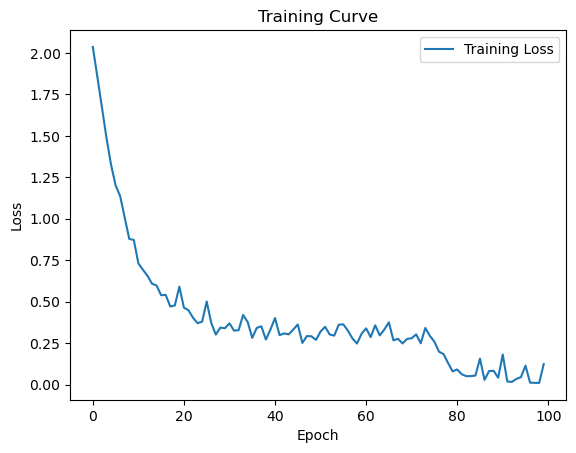

In [15]:
plot_losses(training_loss)

In [16]:
eval_test_Maxout(X_test_tensor,y_test_tensor,model)

Accuracy: 97.25%
Mean Confidence for All Examples: 0.9930
Mean Confidence for Incorrect Predictions: 0.9473


### Creation of the adversarial test set and test evaluation of the Neural Network on the different adversarial examples

In [17]:
input_size = 784
num_classes = 10
device = torch.device("cpu")

# Define the model
model = MaxoutNetworkWithSoftmax(input_size, num_classes)

model = model.to(device)

# Run test for each epsilon

accuracies = []
args = []
epsilons = [-15,-14,-13,-12,-11, -10,-9,-8,-7,-6, -5,-4,-3,-2,-1, 0,1,2,3,4, 5,6,7,8,9, 10,11,12,13,14, 15]

for eps in epsilons:
    accuracy, arg = test_Maxout(model, device, test_dataloader, eps)
    accuracies.append(accuracy)
    args.append(arg)


arg softmax : tensor([[0.3331, 0.3467, 0.1471,  ..., 0.1521, 0.0000, 0.3563],
        [0.5297, 0.4178, 0.1514,  ..., 0.0026, 0.0000, 0.1576],
        [0.1613, 0.2151, 0.1392,  ..., 0.1698, 0.0000, 0.2119],
        ...,
        [0.2921, 0.3347, 0.3839,  ..., 0.0313, 0.0000, 0.0535],
        [0.1905, 0.3382, 0.3770,  ..., 0.1201, 0.0000, 0.0397],
        [0.2770, 0.1883, 0.2371,  ..., 0.0000, 0.0000, 0.0133]],
       grad_fn=<ReluBackward0>)
output : torch.Size([128, 10])
arg softmax : tensor([[0.2882, 0.2520, 0.3536,  ..., 0.0000, 0.0000, 0.0497],
        [0.4948, 0.3960, 0.4112,  ..., 0.0553, 0.0000, 0.0863],
        [0.4358, 0.3192, 0.1753,  ..., 0.0000, 0.0065, 0.1090],
        ...,
        [0.2392, 0.1818, 0.5171,  ..., 0.0000, 0.0000, 0.0000],
        [0.1650, 0.1378, 0.3324,  ..., 0.0596, 0.0000, 0.0824],
        [0.3336, 0.3021, 0.2971,  ..., 0.0000, 0.0000, 0.3252]],
       grad_fn=<ReluBackward0>)
output : torch.Size([128, 10])
arg softmax : tensor([[0.5244, 0.2743, 0.2881,  ..

In [18]:
# Calculate the average value of each column of args
for i in range(len(args)):
    args[i] = args[i].detach().numpy()
    args[i] = np.log(args[i]) - np.log(np.sum(np.exp(args[i]), axis=1, keepdims=True))
    args[i] = args[i].mean(axis=0)

C:\Users\Anna-Louise\AppData\Local\Temp\ipykernel_13052\3751669605.py:4: RuntimeWarning: invalid value encountered in log
  args[i] = np.log(args[i]) - np.log(np.sum(np.exp(args[i]), axis=1, keepdims=True))


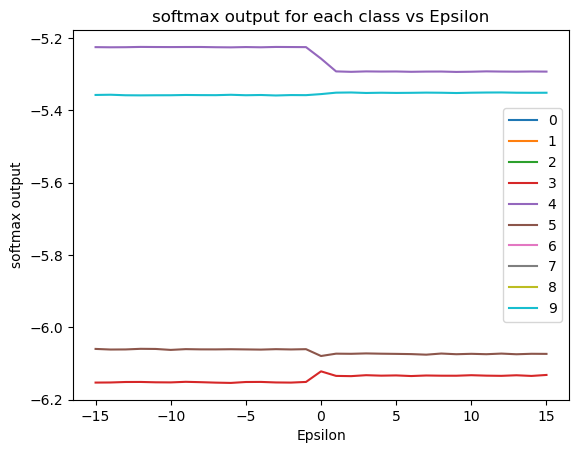

In [19]:
# Plot the average values as a function of epsilon
#plt.figure(figsize=(6, 18))  # Increase the height by a factor of 3
plt.plot(epsilons, [i[:] for i in args])
plt.xlabel('Epsilon')
plt.ylabel('softmax output')

plt.title('softmax output for each class vs Epsilon')
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()
